$$Model \ Inversion \ Attack - Face - SNN - BrainLeaks $$

# Necessary Imports

In [1]:
!pip install snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 4.9 MB/s eta 0:00:00


In [2]:
import snntorch as snn
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
from snntorch import spikegen
from snntorch import surrogate
import torch.nn.functional as F
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML
from torch.utils.data import Subset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from snntorch import utils


# Data Preparation

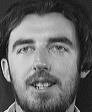

In [3]:
zip_file_path= "/content/Face_ATnT_Data.zip"
import zipfile

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/faces')  # Specify the directory to extract to

import os
from PIL import Image

dataset_path = '/content/faces'  # Path to the extracted dataset folder

# image_file = os.path.join(dataset_path, 'person1/1.png')
image = Image.open('/content/faces/s11/3.pgm')
image

In [4]:
# Set the path to the dataset folder
dataset_path = '/content/faces'

# Define a transform
transform = transforms.Compose([
            transforms.Resize((112, 92)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Load the dataset using the ImageFolder class from torchvision
dataset = ImageFolder(dataset_path, transform=transform)

In [5]:
# Number of persons (40 in the AT&T dataset)
num_persons = 40
indices = list(range(len(dataset)))

# Create a dictionary to store indices for each person
person_indices = {i: [] for i in range(num_persons)}

# Populate the dictionary with indices
for index in indices:
    person_id = index // 10  # Assuming 10 images per person
    person_indices[person_id].append(index)

# Initialize lists to store training and test indices
train_indices = []
test_indices = []

# Split each person's indices
for person_id, indices in person_indices.items():
    train_indices.extend(indices[:8])  # First 8 images for training
    test_indices.extend(indices[8:10])  # Last 2 images for testing

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True , pin_memory=True)
test_loader = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=False)

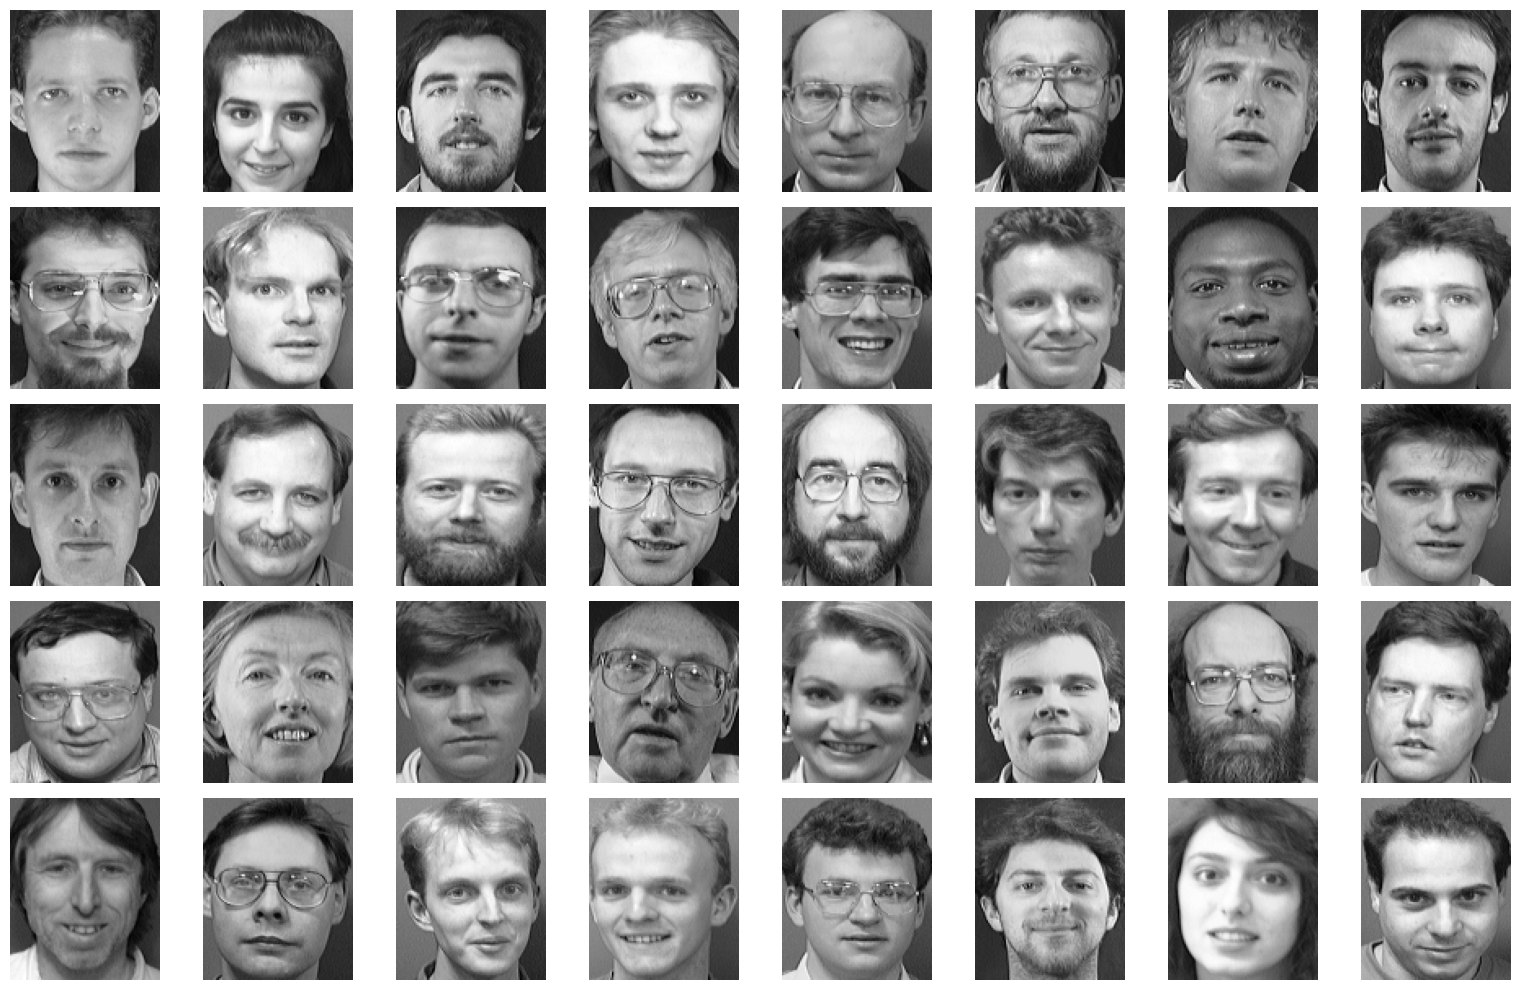

In [6]:
# Ground Truth Images
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(16, 10))
plt.subplots_adjust(hspace=0.5)

for target_class in range(40):

    # Determine the subplot's position in the grid.
    row = target_class // 8
    col = target_class % 8

    # Display
    axes[row, col].imshow(dataset[target_class*10][0].squeeze(),cmap='gray')
    axes[row, col].axis('off')

# Adjust subplot layout and display the figure.
plt.tight_layout()
plt.show()


# SNN Target Model

In [ ]:
# Network Architecture
num_inputs= 112*92
num_hidden = 3000
num_outputs = 40

# Training Parameters
batch_size = 8

# Temporal Dynamics
num_steps = 25      # Number of Time-Steps for Encoding the Static Input
beta = 0.7          # Leakage (Decay) Factor of LIF Neurons

# Other
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Define the gradient for the surrogate function fast_sigmoid with a slope of 40.
spike_grad = surrogate.fast_sigmoid(slope=40)

# Define the neural network architecture using PyTorch's nn.Module.
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers and parameters for the network.
        self.fc1 = nn.Linear(num_inputs, num_hidden)  # First fully connected layer.
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)  # Leaky integrate-and-fire neuron model.
        self.fc2 = nn.Linear(num_hidden, num_outputs)  # Second fully connected layer.
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)  # Another Leaky integrate-and-fire neuron model.

    def forward(self, x):
        # Initialize hidden states and output spikes at t=0.
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk2_rec = []  # List to record output spike activity.
        mem2_rec = []  # List to record membrane potential over time.

        # Loop through time steps.
        for step in range(num_steps):
            cur1 = self.fc1(x[step])  # Apply the first layer to the input at the current time step.
            spk1, mem1 = self.lif1(cur1, mem1)  # Compute spikes and membrane potential for the first neuron layer.
            cur2 = self.fc2(spk1)  # Apply the second layer to the first layer's spikes.
            spk2, mem2 = self.lif2(cur2, mem2)  # Compute spikes and membrane potential for the second neuron layer.

            spk2_rec.append(spk2)  # Record the output spikes for this time step.
            mem2_rec.append(mem2)  # Record the membrane potential for this time step.

        # Stack the recorded spikes and membrane potentials along the time dimension and return them.
        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Create an instance of the neural network (Net) and move it to the specified device (e.g., GPU).
net = Net().to(device)


In [ ]:
# Define functions to print metrics during training loop

def print_batch_accuracy(data, targets, train=False):
    _, output = net(data.view(num_steps, batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")

def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, targets_it, train=True)
    print_batch_accuracy(test_spike_data, testtargets_it, train=False)
    print("\n")

## Model Training

The state dictionary containing the pre-trained model's learned parameters is saved in **'Face_SNN_Weights_Target'** and can be loaded by running the following cell.

In [ ]:
net.load_state_dict(torch.load("/content/Face_SNN_Weights_Target",map_location=device))

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters from "Face_SNN_Weights_Target", you don't need to run this cell.

In [ ]:
# Create an Adam optimizer for training the neural network with a specified learning rate and betas.
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, betas=(0.9, 0.999))

# Instantiate the log softmax function and the negative log-likelihood loss function.
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

# Initialize lists to store training and testing loss values.
loss_hist = []
test_loss_hist = []

# Initialize a counter to keep track of training iterations.
counter = 0

# Outer training loop for epochs
for epoch in range(20):
    minibatch_counter = 0
    data = iter(train_loader) # Create an iterator over the training data.

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator: Convert input data to spike rates for a specified number of time steps.
        spike_data = spikegen.rate(data_it, num_steps=num_steps)


        # Forward pass
        output, mem_rec = net(spike_data.view(num_steps, batch_size, -1))
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform Backpropagation Through Time (BPTT)
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)

        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward(retain_graph=True)
        nn.utils.clip_grad_norm_(net.parameters(), 1) # Clip gradients to prevent exploding gradients.

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())



        ## TEST PHASE

        test_data = itertools.cycle(test_loader) # Create an iterator that cycles through the test_loader indefinitely.
        testdata_it, testtargets_it = next(test_data) # Get the next batch of test data and test targets from the cyclic iterator.
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data = spikegen.rate(testdata_it,num_steps=num_steps)

        # Test set forward pass
        test_output, test_mem_rec = net(test_spike_data.view(num_steps, batch_size, -1))

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy every 50 iterations
        if counter % 40 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1


Epoch 0, Minibatch 0
Train Set Loss: 91.6650619506836
Test Set Loss: 106.36506652832031
Train Set Accuracy: 0.625
Test Set Accuracy: 0.0


Epoch 1, Minibatch 0
Train Set Loss: 91.4464111328125
Test Set Loss: 92.89085388183594
Train Set Accuracy: 0.125
Test Set Accuracy: 0.0


Epoch 2, Minibatch 0
Train Set Loss: 86.49260711669922
Test Set Loss: 87.59806060791016
Train Set Accuracy: 0.125
Test Set Accuracy: 0.25


Epoch 3, Minibatch 0
Train Set Loss: 79.22276306152344
Test Set Loss: 86.83539581298828
Train Set Accuracy: 0.5
Test Set Accuracy: 0.0


Epoch 4, Minibatch 0
Train Set Loss: 88.3324966430664
Test Set Loss: 75.2437744140625
Train Set Accuracy: 0.125
Test Set Accuracy: 0.5


Epoch 5, Minibatch 0
Train Set Loss: 81.91035461425781
Test Set Loss: 76.84806060791016
Train Set Accuracy: 0.375
Test Set Accuracy: 0.5


Epoch 6, Minibatch 0
Train Set Loss: 75.02277374267578
Test Set Loss: 72.51898956298828
Train Set Accuracy: 0.5
Test Set Accuracy: 0.75


Epoch 7, Minibatch 0
Train Set L

In [ ]:
# torch.save(net.state_dict(), "Face_SNN_Weights_Target") # This code saves the model's parameters

## Model Evaluation

In [ ]:
# Evaluation
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        spike_data = spikegen.rate(data,num_steps=num_steps)

        _, output = net(spike_data.view(num_steps, batch_size, -1))
        _, predicted = output.sum(dim=0).max(1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 90.0%


# MI Attack

## Brain Leaks V1

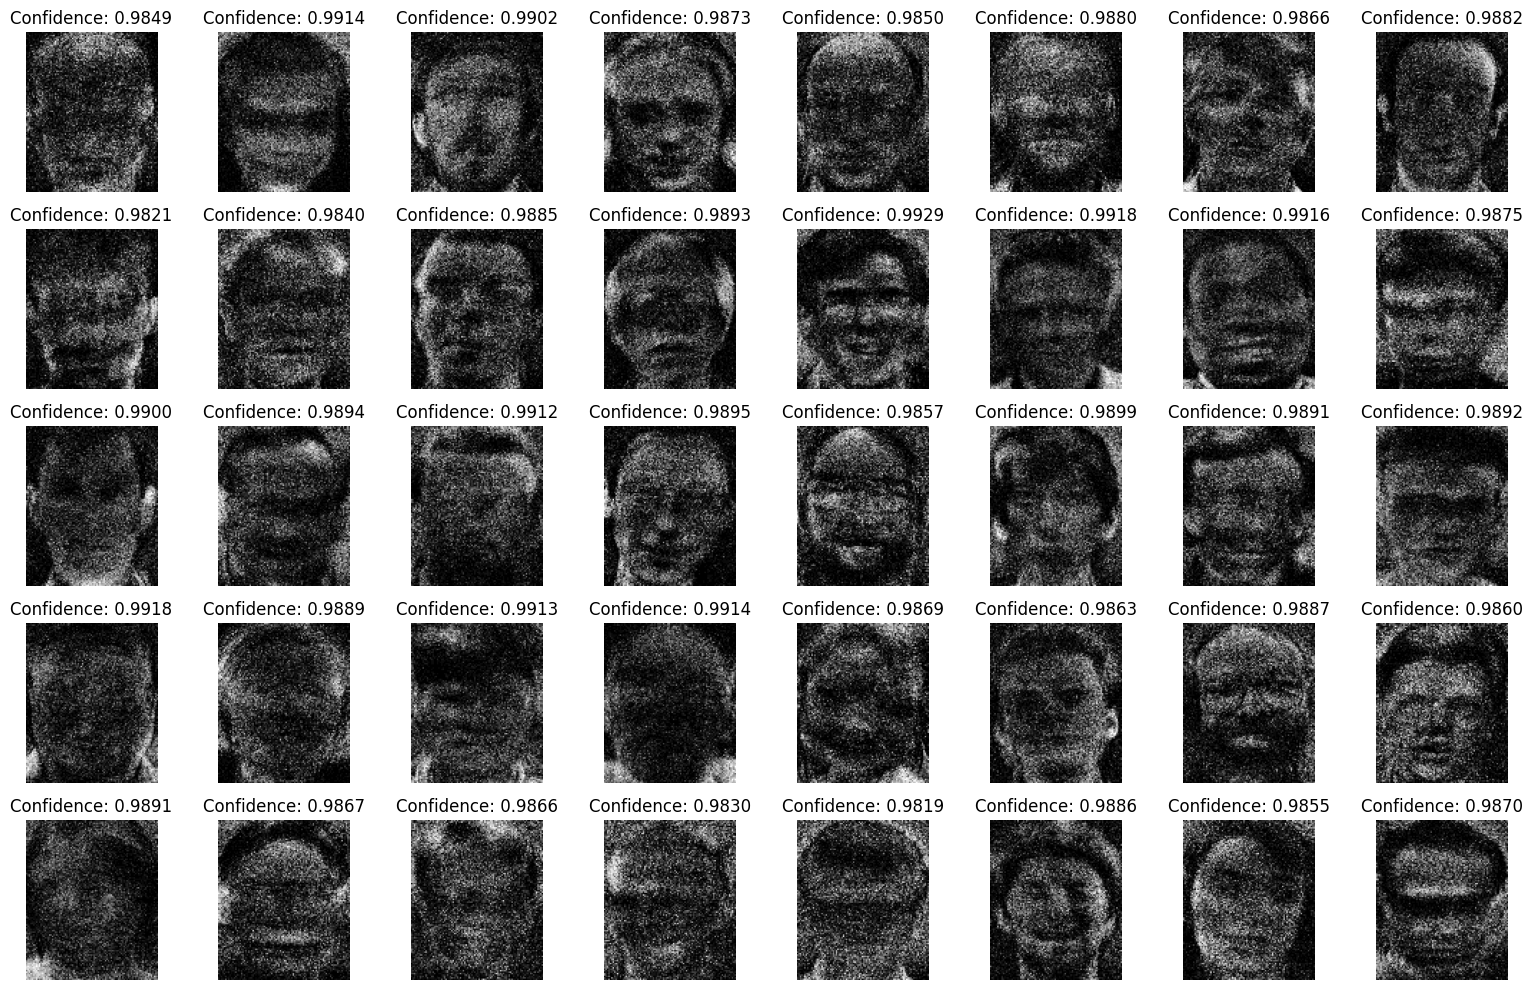

In [ ]:
Inverted_Samples_BL1=[] # A list for storing inverted samples of each label

# Create subplots for displaying visualizations.
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(16, 10))
plt.subplots_adjust(hspace=0.5)

# Loop through each target class
for target_class in range(num_outputs):

    # Initialize spiky input
    spiky_input = torch.zeros((num_steps, 1, num_inputs), requires_grad=True).to(device)

    # Iteratively update spiky input
    for iteration in range(20):

        # Enable gradient computation for spiky input.
        spiky_input.requires_grad_()
        spiky_input.retain_grad()

        # Calculate the cost by maximizing the softmax output for the target class.
        cost = F.softmax(net(spiky_input)[1].squeeze(1), dim=1).mean(dim=0)[target_class]
        cost.backward()

        with torch.no_grad():

            ## 1.

            # Calculate the absolute gradient and normalize it.
            grad = spiky_input.grad

            grad_abs = torch.abs(grad)

            min_val = torch.min(grad_abs)
            max_val = torch.max(grad_abs)
            grad_abs_normalized = (grad_abs - min_val) / (max_val - min_val)

            # Convert Normalized Gradients to Binary

            grad_mask = torch.bernoulli(grad_abs_normalized)



            ## 2. Sign Extraction

            grad_mask_sign = torch.sign(grad) * grad_mask



            ## 3. Overflow-Aware Transformation + Update

            spiky_input = torch.where(spiky_input + grad_mask_sign > 0, torch.tensor(1, dtype=torch.float32), torch.tensor(0, dtype=torch.float32))

    # Calculate the confidence score for the current target class.
    confidence_score = F.softmax(net(spiky_input)[1].squeeze(1), dim=1).mean(dim=0)[target_class]
    Inverted_Samples_BL1.append(spiky_input)


    ## Plotting Phase

    # Determine the subplot's position in the grid.
    row = target_class // 8
    col = target_class % 8

    # Display the decoded spiky input as an image
    axes[row, col].imshow(torch.sum(spiky_input.detach().cpu(), dim=0).view(112, 92), cmap='gray')
    axes[row, col].set_title(f'Confidence: {confidence_score:.4f}')
    axes[row, col].axis('off')

# Adjust subplot layout and display the figure.
plt.tight_layout()
plt.show()

In [ ]:
Inverted_Samples_BL1 = torch.stack(Inverted_Samples_BL1, dim=0) # Convert the list to a tensor

torch.save(Inverted_Samples_BL1,'Face_SNN_Inverted_BL1') # Save the inverted samples

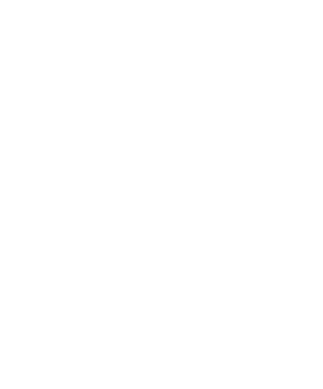

In [ ]:
# Visualize a sample spiky input

fig, ax = plt.subplots()
anim = splt.animator(Inverted_Samples_BL1[2].detach().view(25,112,92), fig, ax)
HTML(anim.to_html5_video())

## Brain Leaks V2

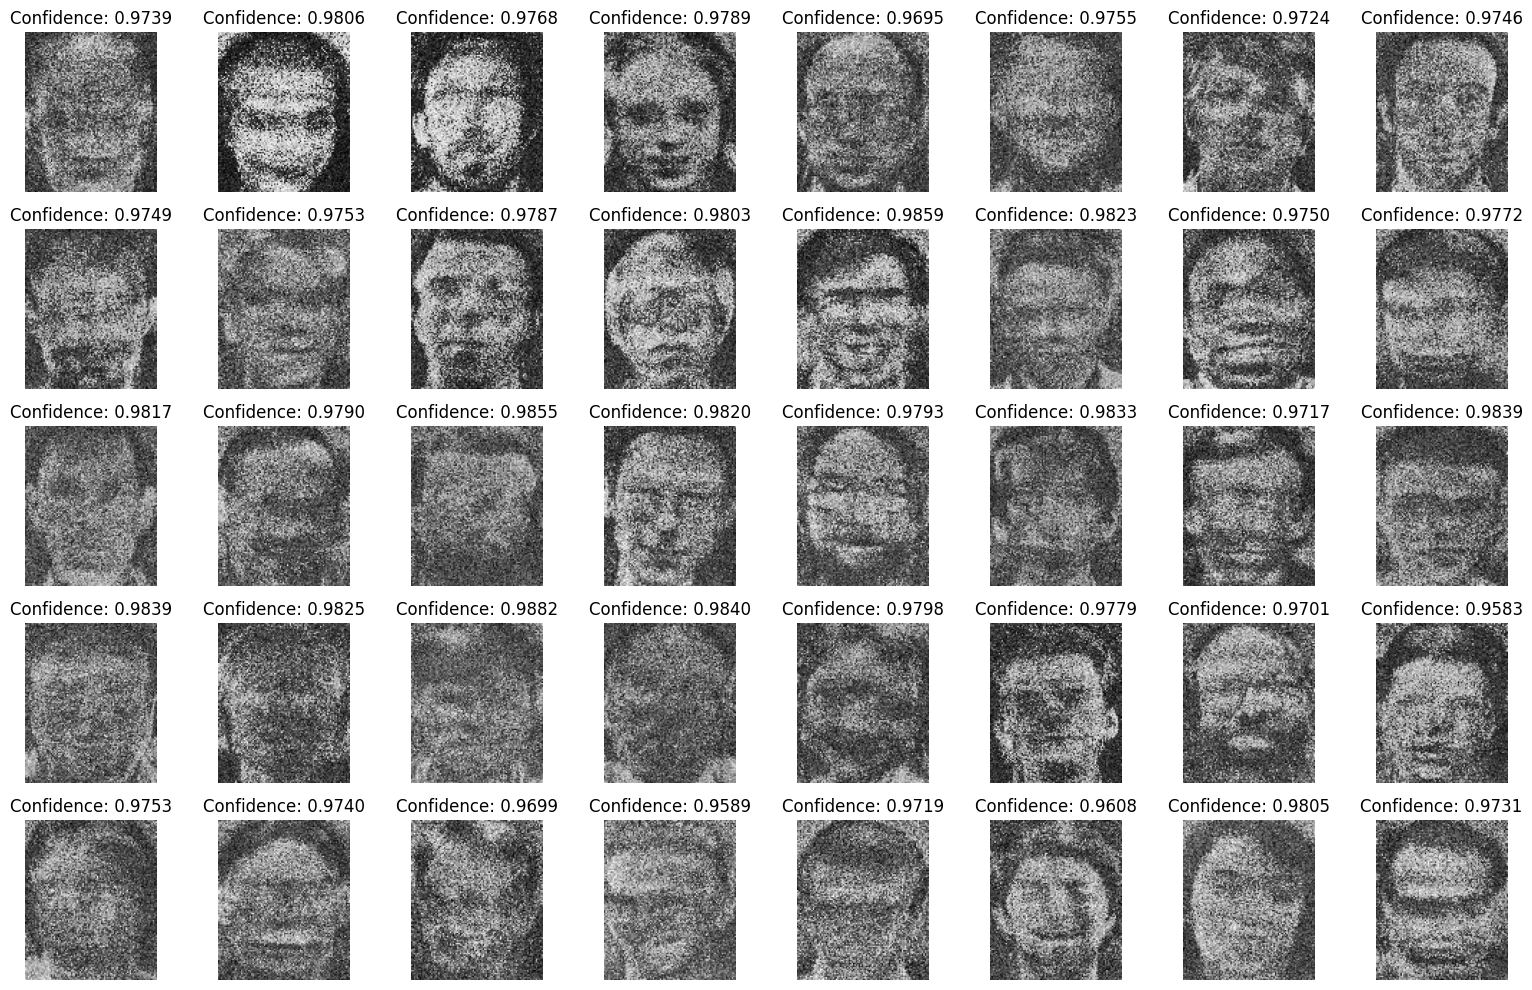

In [ ]:
Inverted_Samples_BL2=[] # A list for storing inverted samples of each label

# Create subplots for displaying visualizations.
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(16, 10))
plt.subplots_adjust(hspace=0.5)


# Define hyperparameters for the optimization process.

population=5 # Population size for using Natural Evolution Strategies
learning_rate = 100 # Gradient descent learning rate
momentum = 0.8 # Momentum
epsilon = 1e-12  # Small constant to prevent division by zero in adaptive learning rate
alpha=0.2 # Controls the rate of accumulation of squared gradients in adaptive learning rate calculations


# Loop through each target class
for target_class in range(num_outputs):

  # Initialize spike probability tensor and create a stack of spiky input tensors.
  spike_probability=torch.zeros((num_steps,1,num_inputs)).to(device)
  spiky_input_stacked=torch.stack([torch.bernoulli(spike_probability) for _ in range(population)]).to(device)

  # Initialize momentum to zero for gradient momentum optimization
  momentum_grad = torch.zeros_like(spike_probability).to(device)

  # Initialize accumulated squared gradients for adaptive learning rate
  squared_grad_sum = torch.zeros_like(spike_probability).to(device)

  # Iteratively update spike probability
  for I in range(10):

    cost_list=[]
    grad_list=[]

    # Iterate through the population of spiky inputs.
    for P in range(population):

      spiky_input=spiky_input_stacked[P]
      spiky_input.requires_grad_()

      # Calculate the cost, including a regularization term.
      cost=1-F.softmax(net(spiky_input)[1].squeeze(1),dim=1).mean(dim=0)[target_class]+0.005*(spiky_input.sum()/spiky_input.numel())
      cost_list.append(cost)
      cost.backward()
      with torch.no_grad():
        grad=spiky_input.grad
        grad_list.append(grad)

    # Aggregate gradients and perform element-wise multiplication with costs.
    grad_aggregated=torch.zeros((num_steps,1,num_inputs)).to(device)


    with torch.no_grad():

      # Iterate through the lists and perform element-wise multiplication
      for g, c in zip(grad_list, cost_list):
          grad_aggregated += (g * c)/sum(cost_list) # Weighted sum of gradients through the population


      # Calculate adaptive learning rates based on squared gradients
      squared_grad_sum += alpha*squared_grad_sum + (1-alpha)*(grad_aggregated**2)
      adaptive_learning_rate = learning_rate / (torch.sqrt(squared_grad_sum) + epsilon)


      # Update spike_probability using the momentum-aided gradient descent
      momentum_grad = momentum * momentum_grad + grad_aggregated
      spike_probability-=adaptive_learning_rate*momentum_grad

      # Clamping and scaling

      # spike_probability=torch.where(spike_probability>0,spike_probability,0) # clamp
      mini=spike_probability.min()
      if mini<0:
        spike_probability-=mini

      maxi=spike_probability.max()
      if maxi>1:
        spike_probability= spike_probability/maxi



      # Generate a stack of spiky inputs based on the updated spike_probability.
      spiky_input_stacked=torch.stack([torch.bernoulli(spike_probability) for _ in range(population)])

  # Calculate the confidence score for the current target class using the one of the generated spiky inputs
  confidence_score=F.softmax(net(spiky_input_stacked[0])[1].squeeze(1),dim=1).mean(dim=0)[target_class]
  Inverted_Samples_BL2.append(spike_probability)


  ## Plotting Phase

  # Determine the subplot's position in the grid.
  row = target_class // 8
  col = target_class % 8

  # Display the decoded spiky input as an image
  axes[row, col].imshow(torch.sum(spiky_input.detach().cpu(), dim=0).view(112, 92), cmap='gray')
  axes[row, col].set_title(f'Confidence: {confidence_score:.4f}')
  axes[row, col].axis('off')

# Adjust subplot layout and display the figure.
plt.tight_layout()
plt.show()

In [ ]:
Inverted_Samples_BL2 = torch.stack(Inverted_Samples_BL2, dim=0) # Convert the list to a tensor

torch.save(Inverted_Samples_BL2,'Face_SNN_Inverted_BL2') # Save the inverted samples

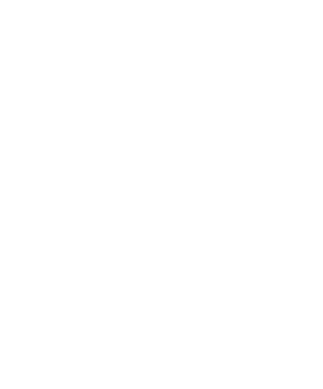

In [ ]:
# Visualize a sample spiky input

fig, ax = plt.subplots()
anim = splt.animator(torch.bernoulli(Inverted_Samples_BL2[11]).detach().view(25,112,92), fig, ax)
HTML(anim.to_html5_video())

# Evaluation Classifier (Convolutional SNN)

In [8]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

num_steps = 25
spike_grad=surrogate.fast_sigmoid(slope=40)
beta=0.7
#  Initialize Network
eval_net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 24, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(12000, 40),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [9]:
def forward_pass(net, num_steps, data):
  mem_rec = []

  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      _, mem_out = net(data[step])

      mem_rec.append(mem_out)

  return  torch.stack(mem_rec)

In [10]:
def print_batch_accuracy(data, targets, train=False):


    output = forward_pass(eval_net, num_steps, data)
    idx = output.sum(dim=0).argmax(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())


    if train:
        print(f"Train Set Accuracy: {acc}")
    else:
        print(f"Test Set Accuracy: {acc}")


def train_printer():
    print(f"Epoch {epoch}, Minibatch {minibatch_counter}")
    print(f"Train Set Loss: {loss_hist[counter]}")
    print(f"Test Set Loss: {test_loss_hist[counter]}")
    print_batch_accuracy(spike_data, targets_it, train=True)
    print_batch_accuracy(test_spike_data, testtargets_it, train=False)
    print("\n")

## Evaluation Classifier Training

The state dictionary containing the pre-trained model's learned parameters is saved in **'Face_SNN_Weights_Eval'** and can be loaded by running the following cell.

In [11]:
eval_net.load_state_dict(torch.load("Face_SNN_Weights_Eval"))

<All keys matched successfully>

Following cell contains the training loop. If you have already loaded learned parameters from "MNIST_SNN_Weights_Eval", you don't need to run this cell.

In [ ]:
## Evaluation Classifier Training

# Create an Adam optimizer for training the neural network with a specified learning rate and betas.
optimizer = torch.optim.Adam(eval_net.parameters(), lr=2e-5, betas=(0.9, 0.999))

# Instantiate the log softmax function and the negative log-likelihood loss function.
log_softmax_fn = nn.LogSoftmax(dim=-1)
loss_fn = nn.NLLLoss()

# Initialize lists to store training and testing loss values.
loss_hist = []
test_loss_hist = []

counter = 0
num_steps=25
# Outer training loop
for epoch in range(1): # This is the last epoch just to check the accuracy and loss. The model needs 50 epoches for training.
    minibatch_counter = 0
    data = iter(train_loader)

    # Minibatch training loop
    for data_it, targets_it in data:
        data_it = data_it.to(device)
        targets_it = targets_it.to(device)

        # Spike generator
        spike_data = spikegen.rate(data_it, num_steps)


        # Forward pass
        mem_rec = forward_pass(eval_net, num_steps, spike_data)
        log_p_y = log_softmax_fn(mem_rec)
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        # Sum loss over time steps to perform BPTT
        for step in range(num_steps):
          loss_val += loss_fn(log_p_y[step], targets_it)
        # print(loss_val)
        # break
        # Gradient Calculation
        optimizer.zero_grad()
        loss_val.backward()
        nn.utils.clip_grad_norm_(eval_net.parameters(), 1)

        # Weight Update
        optimizer.step()

        # Store Loss history
        loss_hist.append(loss_val.item())

        # Test set
        test_data = itertools.cycle(test_loader)
        testdata_it, testtargets_it = next(test_data)
        testdata_it = testdata_it.to(device)
        testtargets_it = testtargets_it.to(device)

        # Test set spike conversion
        test_spike_data = spikegen.rate(testdata_it,num_steps)

        # Test set forward pass
        test_mem_rec = forward_pass(eval_net, num_steps, test_spike_data)

        # Test set loss
        log_p_ytest = log_softmax_fn(test_mem_rec)
        log_p_ytest = log_p_ytest.sum(dim=0)
        loss_val_test = loss_fn(log_p_ytest, testtargets_it)
        test_loss_hist.append(loss_val_test.item())

        # Print test/train loss/accuracy
        if counter % 50 == 0:
            train_printer()
        minibatch_counter += 1
        counter += 1


Epoch 0, Minibatch 0
Train Set Loss: 10.956293106079102
Test Set Loss: 5.521125793457031
Train Set Accuracy: 1.0
Test Set Accuracy: 1.0




In [ ]:
# torch.save(net.state_dict(), "Face_SNN_Weights_Eval")

## Evaluation Classifier Accuracy

In [ ]:
# Evaluation
eval_net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        spike_data = spikegen.rate(data,num_steps=num_steps)

        output = forward_pass(eval_net, num_steps, spike_data)
        predicted = output.sum(dim=0).argmax(1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 97.5%


# Evaluation Phase

In [ ]:
# Function for calculating the accuracy and top-3 accuracy
def count_correct(lst):
    first = 0
    top_3 = 0

    for num in lst:
        # Count the number of occurrences of digit 1
        if num == 1:
          first += 1

        # Count the number of values between 2 and 3 (inclusive)
        if 2 <= num <= 3:
            top_3 += 1

    return first, top_3+first


## Brain Leaks V1

The inverted samples are stored in **"Face_SNN_Inverted_BL1"** and will be loaded at the first line of the following cell. Alternatively, they can be regenerated by running the inversion attack section.

In [ ]:
# Import Inverted Samples
Inv_BL1 = torch.load("Face_SNN_Inverted_BL1",map_location=device)

# Inv_BL1 = Inverted_Samples_BL1.clone() # If you already have the inverted samples in your notebook

In [ ]:
# Attack Evaluation

conf_mat = F.softmax(forward_pass(eval_net,num_steps,Inv_BL1.permute(1, 0, 2,3).view([num_steps,40,1,112,92])),dim=2).mean(0) # Confidence Matrix
rank_mat = torch.argsort(conf_mat,descending=True) # Ranking Matrix
conf_ranks=[]

for i in range(40):
   conf_ranks.append(torch.where(rank_mat[i]==i)[0].item()+1)

DAA_ranks = conf_mat.argmax(0) # Out of all inverted samples, which one is the most similar to digit X


print("\n ** Predicted Labels  :\n\n",conf_mat.max(1)[1])
print("\n\n ** Predicted Labels Confidence  :\n\n",conf_mat.max(1)[0])

print("\n\n\n ** Ground Truth Ranks in Prediction  :\n\n",conf_ranks)
print("\n\n\n ** Number of corrects (First,Top-3)  :\n\n",count_correct(conf_ranks))

print("\n\n ** Confidences of the correct outputs  :\n\n",torch.diag(conf_mat))

print("\n\n ** DAA Ranks  :\n\n",DAA_ranks) # Out of all inverted samples, which one is the most similar to digit X


 ** Predicted Labels  :

 tensor([28,  1, 14, 14, 14,  5,  6, 27, 23, 13, 27, 11, 12, 13, 14, 26, 16, 14,
        13, 27, 14, 21, 14, 23, 24, 24, 26, 27,  6, 23, 30, 32, 32, 14, 32, 32,
        26, 26, 32, 23], device='cuda:0')


 ** Predicted Labels Confidence  :

 tensor([0.1438, 0.4535, 0.4553, 0.2973, 0.3056, 0.7226, 0.6755, 0.3686, 0.3200,
        0.1781, 0.5751, 0.5345, 0.8442, 0.8199, 0.8821, 0.4213, 0.6182, 0.2728,
        0.2754, 0.4778, 0.5650, 0.8806, 0.2862, 0.8996, 0.5602, 0.2029, 0.9073,
        0.8029, 0.1698, 0.2786, 0.7349, 0.3361, 0.8949, 0.6167, 0.4521, 0.3767,
        0.2176, 0.2452, 0.6934, 0.4938], device='cuda:0',
       grad_fn=<MaxBackward0>)



 ** Ground Truth Ranks in Prediction  :

 [5, 1, 2, 6, 6, 1, 1, 2, 6, 10, 3, 1, 1, 1, 1, 5, 1, 7, 7, 3, 2, 1, 5, 1, 1, 6, 1, 1, 2, 2, 1, 4, 1, 3, 5, 5, 7, 3, 3, 4]



 ** Number of corrects (First,Top-3)  :

 (15, 25)


 ** Confidences of the correct outputs  :

 tensor([0.0770, 0.4535, 0.2118, 0.0402, 0.0327, 0.7226, 

In [ ]:
print("Attack Accracy:",count_correct(conf_ranks)[0]/40)
print("\n\nTop-3 Attack Accuracy:", count_correct(conf_ranks)[1]/40)
print("\n\n ** Average Confidence of correct outputs",torch.diag(conf_mat).mean().item())
print("\n\nDAA:", (sum(DAA_ranks==torch.tensor(range(40)).to(device)).item())/40)

Attack Accracy: 0.375


Top-3 Attack Accuracy: 0.625


 ** Average Confidence of correct outputs 0.3409234881401062


DAA: 0.9


## Brain Leaks V2

The inverted samples are stored in **"Face_SNN_Inverted_BL2"** and will be loaded at the first line of the following cell. Alternatively, they can be regenerated by running the inversion attack section.

In [ ]:
# Import Inverted Samples
Inv_BL2 = torch.load("Face_SNN_Inverted_BL2",map_location=device)

# Inv_BL2 = Inverted_Samples_BL2.clone() # If you already have the inverted samples in your notebook

In [ ]:
# Attack Evaluation

conf_mat = F.softmax(forward_pass(eval_net,num_steps,torch.bernoulli(Inv_BL2).permute(1, 0, 2,3).view([num_steps,40,1,112,92])),dim=2).mean(0) # Confidence Matrix
rank_mat = torch.argsort(conf_mat,descending=True) # Ranking Matrix
conf_ranks=[]

for i in range(40):
   conf_ranks.append(torch.where(rank_mat[i]==i)[0].item()+1)

DAA_ranks = conf_mat.argmax(0) # Out of all inverted samples, which one is the most similar to digit X


print("\n ** Predicted Labels  :\n\n",conf_mat.max(1)[1])
print("\n\n ** Predicted Labels Confidence  :\n\n",conf_mat.max(1)[0])

print("\n\n\n ** Ground Truth Ranks in Prediction  :\n\n",conf_ranks)
print("\n\n\n ** Number of corrects (First,Top-3)  :\n\n",count_correct(conf_ranks))

print("\n\n ** Confidences of the correct outputs  :\n\n",torch.diag(conf_mat))

print("\n\n ** DAA Ranks  :\n\n",DAA_ranks) # Out of all inverted samples, which one is the most similar to digit X


 ** Predicted Labels  :

 tensor([ 0,  6,  2,  6,  4, 30,  6,  7,  8,  6,  6, 11,  6, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 24, 24, 24, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         6, 37, 38, 39], device='cuda:0')


 ** Predicted Labels Confidence  :

 tensor([0.3986, 0.2790, 0.3472, 0.1180, 0.5524, 0.2337, 0.8150, 0.6898, 0.6927,
        0.3083, 0.2417, 0.4099, 0.2021, 0.7264, 0.6249, 0.5256, 0.6779, 0.1813,
        0.2849, 0.1939, 0.8772, 0.4223, 0.2128, 0.4860, 0.7660, 0.3127, 0.5542,
        0.8314, 0.4297, 0.7200, 0.7490, 0.1812, 0.6588, 0.2981, 0.5288, 0.5315,
        0.3669, 0.2868, 0.6402, 0.2152], device='cuda:0',
       grad_fn=<MaxBackward0>)



 ** Ground Truth Ranks in Prediction  :

 [1, 2, 1, 3, 1, 3, 1, 1, 1, 3, 5, 1, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1]



 ** Number of corrects (First,Top-3)  :

 (30, 36)


 ** Confidences of the correct outputs  :

 tensor([0.3986, 0.1488, 0.3472, 0.1024, 0.5524, 0.1498, 

In [ ]:
print("Attack Accracy:",count_correct(conf_ranks)[0]/40)
print("\n\nTop-3 Attack Accuracy:", count_correct(conf_ranks)[1]/40)

print("\n\n ** Average Confidence of correct outputs",torch.diag(conf_mat).mean().item())
print("\n\nDAA:", (sum(DAA_ranks==torch.tensor(range(40)).to(device)).item())/40)

Attack Accracy: 0.75


Top-3 Attack Accuracy: 0.9


 ** Average Confidence of correct outputs 0.4204219877719879


DAA: 1.0


We generate different versions of the inverted samples through Bernoulli sampling and compute the metrics' statistics:

In [ ]:
# Averaging Attack Evaluation for Brain Leaks V2
Acc_list=[]
Top3_list=[]

for i in range(1000):


  conf_mat = F.softmax(forward_pass(eval_net,num_steps,torch.bernoulli(Inv_BL2).permute(1, 0, 2,3).view([num_steps,40,1,112,92])),dim=2).mean(0) # Confidence Matrix
  rank_mat = torch.argsort(conf_mat,descending=True) # Ranking Matrix
  conf_ranks=[]

  for i in range(40):
    conf_ranks.append(torch.where(rank_mat[i]==i)[0].item()+1)
  corrects,top3 = count_correct(conf_ranks)
  Acc_list.append(corrects/40)
  Top3_list.append(top3/40)



In [ ]:
print("Mean of Attack Accracy:",np.array(Acc_list).mean())
print("\n\nSTD of Attack Accracy:",np.array(Acc_list).std())

print("\n\nMean of Top-3 Attack Accuracy:", np.array(Top3_list).mean())
print("\n\nSTD of Top-3 Attack Accuracy:", np.array(Top3_list).std())


Mean of Attack Accracy: 0.7127499999999999


STD of Attack Accracy: 0.02249861106824152


Mean of Top-3 Attack Accuracy: 0.8927750000000001


STD of Top-3 Attack Accuracy: 0.018766309573275203
